In [1]:
import numpy as np
from numpy import linalg as la
from numpy import *
import numpy.linalg as la

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
import os
import scipy.io as sio






from koopman_pseudospec_qr import KoopPseudoSpecQR
from matplotlib.colors import ListedColormap, BoundaryNorm

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.10.0
GPU is available


In [2]:
# Load the specified MAT-file using scipy.io.loadmat()
file_path = 'data/pendulum_data/data_pendulum_90.mat'
data_pendulum = loadmat(file_path)

In [3]:
# Assuming the loaded MAT-file is named data_pendulum_90
X = data_pendulum['DATA_X']
Y = data_pendulum['DATA_Y']

print(X.shape)

(90000, 2)


In [4]:
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

Outer Epoch 1/30
Epoch 1/2
2/2 [==============================] - 5s 1s/step - loss: 2.2697e-08 - val_loss: 1.7051e-07
Epoch 2/2
2/2 [==============================] - 3s 1s/step - loss: 1.7238e-06 - val_loss: 6.2746e-06
Outer Epoch 2/30
Epoch 1/2
2/2 [==============================] - 3s 1s/step - loss: 6.4312e-06 - val_loss: 3.2958e-06
Epoch 2/2
2/2 [==============================] - 3s 965ms/step - loss: 3.4071e-06 - val_loss: 3.2502e-06
Outer Epoch 3/30
Epoch 1/2
2/2 [==============================] - 3s 1s/step - loss: 3.3965e-06 - val_loss: 1.4421e-06
Epoch 2/2
2/2 [==============================] - 3s 958ms/step - loss: 1.6098e-06 - val_loss: 2.4341e-06
Outer Epoch 4/30
Epoch 1/2
2/2 [==============================] - 3s 982ms/step - loss: 2.3804e-06 - val_loss: 8.7991e-07
Epoch 2/2
2/2 [==============================] - 3s 975ms/step - loss: 1.0314e-06 - val_loss: 1.5323e-06
Outer Epoch 5/30
Epoch 1/2
2/2 [==============================] - 3s 979ms/step - loss: 1.5127e-06 - val

100%|██████████| 3721/3721 [02:57<00:00, 21.02it/s]
C:\Users\xyc93\AppData\Local\Temp\ipykernel_20000\237982283.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  RES[zero_real_indices] = lower_bound + np.imag(RES[zero_real_indices]) * 1j


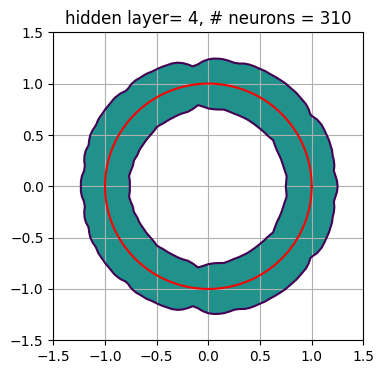

Number of rows in Psi_X for num_neuron 320: 62999
Shape of G for num_neuron 320: (300, 300)
cond(G) is: 2.2926187325386424e+20


100%|██████████| 3721/3721 [02:52<00:00, 21.63it/s]


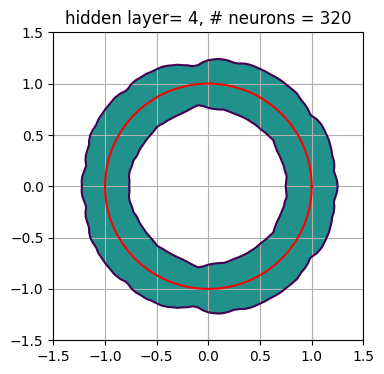

Number of rows in Psi_X for num_neuron 330: 62999
Shape of G for num_neuron 330: (300, 300)
cond(G) is: 2.8079104537363107e+20


100%|██████████| 3721/3721 [02:45<00:00, 22.50it/s]


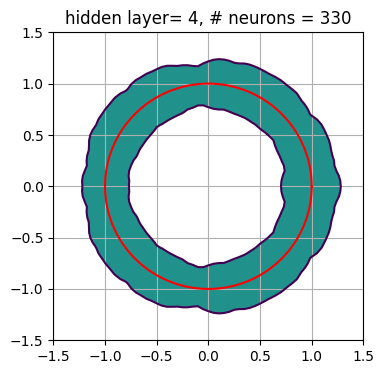

In [ ]:
### Train the basis using NN-resDMD
### Calculate for chosen number of basis ###
# Results from solver_resdmd_tf
from solver_resdmd_tf import KoopmanNN, KoopmanSolver
import glob

dic_size = 300

# List of different num_neuron values to test
num_neuron_list = [310, 320, 330]

# Loop over each num_neuron value
for num_neuron in num_neuron_list:
    # Initialize the basis function with the current num_neuron value
    basis_function = KoopmanNN(layer_sizes=[num_neuron, num_neuron, num_neuron, num_neuron], n_psi_train=dic_size - 3) 
    
    # Initialize the solver with the defined basis function and target dimension from data_x_train
    solver = KoopmanSolver(dic=basis_function,
                             target_dim=np.shape(data_x_train)[-1],
                             reg=0.1)
    
    # Train the model
    solver.build(data_train=data_train,
                 data_valid=data_valid,
                 epochs=30,
                 batch_size=50000,
                 lr=1e-5,
                 log_interval=10,
                 lr_decay_factor=0.8)
    
    # Extract results from the trained model
    evalues = solver.eigenvalues.T
    efuns = solver.eigenfunctions(X)
    kpm_modes = solver.compute_mode().T
    N_dict = np.shape(evalues)[0]
    Psi_X = solver.get_Psi_X().numpy()
    Psi_Y = solver.get_Psi_Y().numpy()
    Koopman_matrix_K = solver.K.numpy()
    
    outputs = {
        'efuns': efuns,
        'evalues': evalues,
        'kpm_modes': kpm_modes,
        'N_dict': N_dict,
        'K': Koopman_matrix_K,
        'Psi_X': Psi_X,
        'Psi_Y': Psi_Y,
    }
    
    # Define the folder path to save the data and create it if it doesn't exist
    folder_path = 'data/pendulum_data'
    os.makedirs(folder_path, exist_ok=True)
    
    # Generate a filename that distinguishes the results by num_neuron value
    file_path = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis_{num_neuron}neuron_hlayer_4.mat')
    
    # Save the outputs to a .mat file
    sio.savemat(file_path, outputs)
    print(f'Saved outputs for num_neuron={num_neuron}, n_psi_train={N_dict} to {file_path}')




# Define the folder path where the .mat files are stored
folder_path = 'data/pendulum_data'

# List of num_neuron values used when saving the files
num_neuron_list = [310, 320, 330]

# Loop over each num_neuron value
for num_neuron in num_neuron_list:
    # Construct the file pattern based on the naming convention used when saving
    file_pattern = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis_{num_neuron}neuron_hlayer_4.mat')
    file_list = glob.glob(file_pattern)
    
    # If no file is found, print a message and continue to the next value
    if len(file_list) == 0:
        print(f"No file found for num_neuron = {num_neuron}")
        continue
    
    # Assume that only one file matches the pattern
    file_path = file_list[0]
    
    # Load the data from the .mat file
    data_pendulum = loadmat(file_path)
    Psi_X = data_pendulum['Psi_X']
    Psi_Y = data_pendulum['Psi_Y']
    # 'N_dict' is stored as an array, take the first element
    dic_size = data_pendulum['N_dict'][0]
    
    # Load eigenvalues; assuming they are stored under the key 'evalues'
    evalues = data_pendulum['evalues']
        
    #########################################
    # Plot the pseudospectrum
    #########################################
    # Determine the number of rows in Psi_X
    m = Psi_X.shape[0]
    print(f"Number of rows in Psi_X for num_neuron {num_neuron}: {m}")
    
    # Create a weight vector of ones
    W = np.ones((m, 1), dtype=np.double)
    
    # Compute the Gram matrix of Psi_X
    G = np.dot(Psi_X.T, Psi_X)
    print(f"Shape of G for num_neuron {num_neuron}: {G.shape}")
    print('cond(G) is:', la.cond(G))
    
    # Create grid points for plotting the pseudospectrum
    x_pts = np.arange(-1.5, 1.5 + 0.05, 0.05)
    y_pts = x_pts
    x_pts_mesh, y_pts_mesh = np.meshgrid(x_pts, y_pts)
    z_pts = x_pts_mesh + 1j * y_pts_mesh
    z_pts = z_pts.ravel()
    
    # Compute the pseudospectrum using the provided function KoopPseudoSpecQR
    RES = KoopPseudoSpecQR(Psi_X, Psi_Y, W, z_pts)
    RES = RES.reshape(x_pts_mesh.shape)
    
    # Avoid division by zero: replace zero real parts with a small lower bound
    lower_bound = 1e-16
    zero_real_indices = np.nonzero(np.real(RES) == 0)
    RES[zero_real_indices] = lower_bound + np.imag(RES[zero_real_indices]) * 1j
    
    # Plot the pseudospectrum
    plt.figure(figsize=(4, 4))
    # Define levels for contouring using the logarithm of the reciprocal of the real part of RES
    v = np.array([0.25, 1e-64])
    plt.contourf(x_pts_mesh, y_pts_mesh, np.log10(1 / np.real(RES)), levels=np.log10(1 / v))
    plt.contour(x_pts_mesh, y_pts_mesh, np.log10(1 / np.real(RES)), levels=np.log10(1 / v))
    
    # Overlay a red circle (unit circle) for reference
    circle_phi = np.arange(0, 2 * np.pi, 2 * np.pi / 1000)
    plt.plot(np.cos(circle_phi), np.sin(circle_phi), color='red')
    
    # plt.title(f'N_K = {dic_size}, # neurons = {num_neuron}')
    plt.title(f'hidden layer= 4, # neurons = {num_neuron}')
    plt.grid()
    plt.show()

Outer Epoch 1/30
Epoch 1/2
2/2 [==============================] - 4s 1s/step - loss: 2.1277e-08 - val_loss: 9.3683e-08
Epoch 2/2
2/2 [==============================] - 3s 892ms/step - loss: 1.2720e-06 - val_loss: 4.9315e-06
Outer Epoch 2/30
Epoch 1/2
2/2 [==============================] - 3s 908ms/step - loss: 5.1546e-06 - val_loss: 1.2907e-06
Epoch 2/2
2/2 [==============================] - 3s 890ms/step - loss: 1.8470e-06 - val_loss: 2.5685e-06
Outer Epoch 3/30
Epoch 1/2
2/2 [==============================] - 3s 923ms/step - loss: 2.4140e-06 - val_loss: 1.8791e-06
Epoch 2/2
2/2 [==============================] - 3s 893ms/step - loss: 2.0263e-06 - val_loss: 1.0514e-06
Outer Epoch 4/30
Epoch 1/2
2/2 [==============================] - 3s 913ms/step - loss: 1.1063e-06 - val_loss: 1.3108e-06
Epoch 2/2
2/2 [==============================] - 3s 882ms/step - loss: 1.3380e-06 - val_loss: 7.5834e-07
Outer Epoch 5/30
Epoch 1/2
2/2 [==============================] - 3s 917ms/step - loss: 8.0802e

100%|██████████| 3721/3721 [02:35<00:00, 23.90it/s]
C:\Users\xyc93\AppData\Local\Temp\ipykernel_20000\1807690532.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  RES[zero_real_indices] = lower_bound + np.imag(RES[zero_real_indices]) * 1j


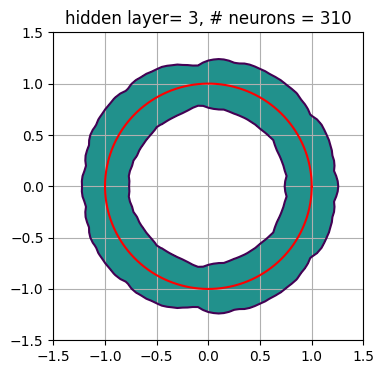

Number of rows in Psi_X for num_neuron 320: 62999
Shape of G for num_neuron 320: (300, 300)
cond(G) is: 3.9140231457183184e+20


100%|██████████| 3721/3721 [02:33<00:00, 24.23it/s]


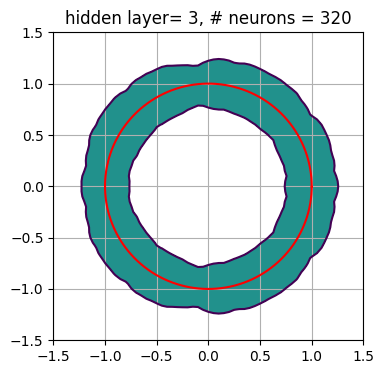

Number of rows in Psi_X for num_neuron 330: 62999
Shape of G for num_neuron 330: (300, 300)
cond(G) is: 2.584662306699283e+20


100%|██████████| 3721/3721 [02:28<00:00, 25.03it/s]


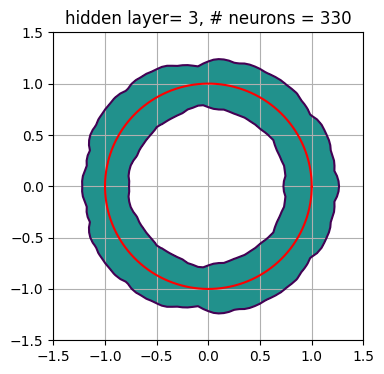

In [6]:
### Train the basis using NN-resDMD
### Calculate for chosen number of basis ###
# Results from solver_resdmd_tf
from solver_resdmd_tf import KoopmanNN, KoopmanSolver
import glob

dic_size = 300

# List of different num_neuron values to test
num_neuron_list = [310, 320, 330]

# Loop over each num_neuron value
for num_neuron in num_neuron_list:
    # Initialize the basis function with the current num_neuron value
    basis_function = KoopmanNN(layer_sizes=[num_neuron, num_neuron, num_neuron], n_psi_train=dic_size - 3) 
    
    # Initialize the solver with the defined basis function and target dimension from data_x_train
    solver = KoopmanSolver(dic=basis_function,
                             target_dim=np.shape(data_x_train)[-1],
                             reg=0.1)
    
    # Train the model
    solver.build(data_train=data_train,
                 data_valid=data_valid,
                 epochs=30,
                 batch_size=50000,
                 lr=1e-5,
                 log_interval=10,
                 lr_decay_factor=0.8)
    
    # Extract results from the trained model
    evalues = solver.eigenvalues.T
    efuns = solver.eigenfunctions(X)
    kpm_modes = solver.compute_mode().T
    N_dict = np.shape(evalues)[0]
    Psi_X = solver.get_Psi_X().numpy()
    Psi_Y = solver.get_Psi_Y().numpy()
    Koopman_matrix_K = solver.K.numpy()
    
    outputs = {
        'efuns': efuns,
        'evalues': evalues,
        'kpm_modes': kpm_modes,
        'N_dict': N_dict,
        'K': Koopman_matrix_K,
        'Psi_X': Psi_X,
        'Psi_Y': Psi_Y,
    }
    
    # Define the folder path to save the data and create it if it doesn't exist
    folder_path = 'data/pendulum_data'
    os.makedirs(folder_path, exist_ok=True)
    
    # Generate a filename that distinguishes the results by num_neuron value
    file_path = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis_{num_neuron}neuron_hlayer_3.mat')
    
    # Save the outputs to a .mat file
    sio.savemat(file_path, outputs)
    print(f'Saved outputs for num_neuron={num_neuron}, n_psi_train={N_dict} to {file_path}')



# Define the folder path where the .mat files are stored
folder_path = 'data/pendulum_data'

# List of num_neuron values used when saving the files
num_neuron_list = [300, 310, 320, 330]

# Loop over each num_neuron value
for num_neuron in num_neuron_list:
    # Construct the file pattern based on the naming convention used when saving
    file_pattern = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis_{num_neuron}neuron_hlayer_3.mat')
    file_list = glob.glob(file_pattern)
    
    # If no file is found, print a message and continue to the next value
    if len(file_list) == 0:
        print(f"No file found for num_neuron = {num_neuron}")
        continue
    
    # Assume that only one file matches the pattern
    file_path = file_list[0]
    
    # Load the data from the .mat file
    data_pendulum = loadmat(file_path)
    Psi_X = data_pendulum['Psi_X']
    Psi_Y = data_pendulum['Psi_Y']
    # 'N_dict' is stored as an array, take the first element
    dic_size = data_pendulum['N_dict'][0]
    
    # Load eigenvalues; assuming they are stored under the key 'evalues'
    evalues = data_pendulum['evalues']
        
    #########################################
    # Plot the pseudospectrum
    #########################################
    # Determine the number of rows in Psi_X
    m = Psi_X.shape[0]
    print(f"Number of rows in Psi_X for num_neuron {num_neuron}: {m}")
    
    # Create a weight vector of ones
    W = np.ones((m, 1), dtype=np.double)
    
    # Compute the Gram matrix of Psi_X
    G = np.dot(Psi_X.T, Psi_X)
    print(f"Shape of G for num_neuron {num_neuron}: {G.shape}")
    print('cond(G) is:', la.cond(G))
    
    # Create grid points for plotting the pseudospectrum
    x_pts = np.arange(-1.5, 1.5 + 0.05, 0.05)
    y_pts = x_pts
    x_pts_mesh, y_pts_mesh = np.meshgrid(x_pts, y_pts)
    z_pts = x_pts_mesh + 1j * y_pts_mesh
    z_pts = z_pts.ravel()
    
    # Compute the pseudospectrum using the provided function KoopPseudoSpecQR
    RES = KoopPseudoSpecQR(Psi_X, Psi_Y, W, z_pts)
    RES = RES.reshape(x_pts_mesh.shape)
    
    # Avoid division by zero: replace zero real parts with a small lower bound
    lower_bound = 1e-16
    zero_real_indices = np.nonzero(np.real(RES) == 0)
    RES[zero_real_indices] = lower_bound + np.imag(RES[zero_real_indices]) * 1j
    
    # Plot the pseudospectrum
    plt.figure(figsize=(4, 4))
    # Define levels for contouring using the logarithm of the reciprocal of the real part of RES
    v = np.array([0.25, 1e-64])
    plt.contourf(x_pts_mesh, y_pts_mesh, np.log10(1 / np.real(RES)), levels=np.log10(1 / v))
    plt.contour(x_pts_mesh, y_pts_mesh, np.log10(1 / np.real(RES)), levels=np.log10(1 / v))
    
    # Overlay a red circle (unit circle) for reference
    circle_phi = np.arange(0, 2 * np.pi, 2 * np.pi / 1000)
    plt.plot(np.cos(circle_phi), np.sin(circle_phi), color='red')
    
    # plt.title(f'N_K = {dic_size}, # neurons = {num_neuron}')
    plt.title(f'hidden layer= 3, # neurons = {num_neuron}')
    plt.grid()
    plt.show()